#### Imports

In [23]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.metrics.pairwise import euclidean_distances

#### Creating the dataset and applying z-score normalization (using sklearns _StandardScaler_) 

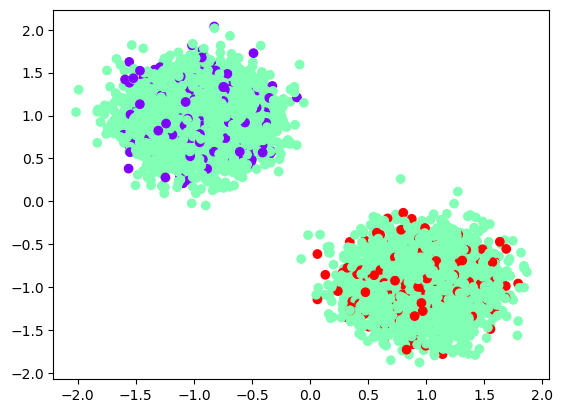

In [7]:
# Generate a dataset with 2 classes and clusters
X, y = make_blobs(n_samples=10000, centers=2, random_state=42)

# Reset the class labels from (y = 0,1) to (y = -1,1)
y[y == 0] = -1

#standardization 
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Randomly remove 90% of labels
y_new = np.copy(y)
remove_idx = np.sort(np.random.choice(len(y), size=int(len(y)*90/100), replace=False))
y_unlabeled_target = y[remove_idx] # Save the removed labels for later use
y_new[remove_idx] = 0 # Set the removed labels to 0

# Split X into labeled (y = -1, 1) and unlabeled (y = 0) sets
labeled_idx = np.where(y_new != 0)
unlabeled_idx = np.where(y_new == 0)
x_labeled = X[labeled_idx]
x_unlabeled = X[unlabeled_idx]
y_labeled = y_new[labeled_idx]
y_unlabeled = y_new[unlabeled_idx]

# Plot the points with different colors according to their labels
plt.scatter(X[:, 0], X[:, 1], c=y_new, cmap='rainbow')
plt.show()

In [8]:
len(y_unlabeled_target)

9000

In [9]:
#print(X,sum(y[y==1]))
print("x unlabeled:",x_unlabeled.shape)
print("x labeled :",x_labeled.shape)
print("y unlabeled:",y_unlabeled.shape)
print("y labeled",y_labeled.shape)

x unlabeled: (9000, 2)
x labeled : (1000, 2)
y unlabeled: (9000,)
y labeled (1000,)


#### Defining the similarity measure : gaussian weights 

The Gaussian similarity function between two vectors $x_1$ and $x_2$ is :
$$
K(x_1, x_2) = \exp\left(-\frac{||x_1 - x_2||^2}{2\sigma^2}\right)
$$

In [10]:
# this function directly computes the similarity matrix
def gaussian_similarity(x1, x2, sigma=1.0):
    D = euclidean_distances(x1, x2, squared=True)
    S = np.exp(-D / (2.0 * sigma**2))
    return S

In [11]:
%%time
# similarity matrix labeled-unlabeled
w_labeled_unlabeled = gaussian_similarity(x_labeled, x_unlabeled,sigma=0.1)

# similarity matrix unlabeled-unlabeled
w_unlabeled_unlabeled = gaussian_similarity(x_unlabeled, x_unlabeled,sigma=0.1)

CPU times: total: 3.25 s
Wall time: 2.07 s


In [12]:
# checking that the shape is correct
print(w_labeled_unlabeled.shape)
w_unlabeled_unlabeled.shape

(1000, 9000)


(9000, 9000)

Consider the problem $$\min_{y \in R^u} \left( \sum_{i=1}^l \sum_{j=1}^u w_{ij}(y_j - \bar{y}_i)^2 + \frac{1}{2}\sum_{i=1}^u \sum_{j=1}^u \bar{w}_{ij}(y_i-y_j)^2 \right)$$

In [13]:
# Define the Loss Function 
def loss(labeled, unlabeled):

    Y = np.copy(unlabeled).astype("float64").reshape((-1,1))
    Y_bar = np.copy(labeled).astype("float64").reshape((-1,1))
    Y_minus_Y_bar = Y-Y_bar.T
    Y_minus_Y_bar_sq = np.power(Y_minus_Y_bar, 2)
    labeled_unlabeled_loss_matrix = Y_minus_Y_bar_sq * w_labeled_unlabeled.T
    labeled_unlabeled_loss = np.sum(labeled_unlabeled_loss_matrix)

    Y_minus_Y = Y-Y.T
    Y_minus_Y_sq = np.power(Y_minus_Y, 2)
    unlabeled_unlabeled_loss_matrix = Y_minus_Y_sq * w_unlabeled_unlabeled.T
    unlabeled_unlabeled_loss = np.sum(unlabeled_unlabeled_loss_matrix)

    return labeled_unlabeled_loss + unlabeled_unlabeled_loss/2

In [14]:
# Import additional functions from sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

import numpy as np

def accuracy(y_unlabeled_target, y_unlabeled_gradient):
    # Convert the predicted labels to -1 or 1 by thresholding at 0
    y_unlabeled_gradient_binary = np.where(y_unlabeled_gradient >= 0, 1, -1)
    
    # Calculate the accuracy by comparing the binary predicted labels with the true labels
    accuracy = np.mean(y_unlabeled_target == y_unlabeled_gradient_binary)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_unlabeled_target, y_unlabeled_gradient_binary)
    
    # Calculate the F1 score
    f1 = f1_score(y_unlabeled_target, y_unlabeled_gradient_binary)
    
    return accuracy, cm, f1

In [15]:
y_unlabeled_target

array([ 1,  1, -1, ...,  1, -1,  1])

Following is the function used to calculate the gradient, which for a single variable is:
$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + \sum_{i=0}^u\bar{w}_{ij}(y^j - y^i) \\
& = (2 \sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})y^j - 2 \sum_{i=0}^lw_{ij}\bar{y}^i - \sum_{i=0}^u\bar{w}_{ij}y^i
\end{align*}
$$

In [16]:
sumbycol_label_unlabel = np.sum(w_labeled_unlabeled, axis=0).reshape((-1,1))
sumbycol_unlabel_unlabel = np.sum(w_unlabeled_unlabeled, axis=0).reshape((-1,1))
grad_first_term = 2 * (sumbycol_label_unlabel + sumbycol_unlabel_unlabel)
grad_second_term = 2 * np.multiply(y_labeled.reshape((-1,1)), w_labeled_unlabeled).sum(0).reshape((-1,1))

In [17]:
#using the pre-defined constant vectors, we calculate the third term that 
# depends on the unlabled vector in order to compute the expanded form of the 
# gradient 
def gradient(unlabeled):
    unlabeled = unlabeled.reshape((-1,1))
    third_term = np.multiply(unlabeled,w_unlabeled_unlabeled).sum(0).reshape((-1,1))
    return (grad_first_term * unlabeled - grad_second_term - third_term).reshape((-1,))

In [18]:
gradient(y_unlabeled_target)

array([ 488.54867581,  387.85857434, -535.30750652, ...,  431.69276281,
       -454.94938411,   88.74571991])

Hessians and Lipschitz

In [19]:
def hessian_matrix(w_unlabeled_unlabeled, w_labeled_unlabeled, y_unlabeled):
    mat = 2 * np.copy(-w_unlabeled_unlabeled)
    for i in range(len(y_unlabeled)):
        mat[i][i] = 2 * (np.sum(w_labeled_unlabeled[:,i]) + np.sum(w_unlabeled_unlabeled[:,i]))
    return mat

def estimate_lipschitz_constant(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]

In [20]:
hessian = hessian_matrix(w_unlabeled_unlabeled, w_labeled_unlabeled, y_unlabeled)

In [21]:
%%time
print("Estimating Lipschitz constant for the whole function")
L = estimate_lipschitz_constant(hessian)
print(f"Lipschitz constant: {L}")

print("Step size: 1/L")
step_size = 1/L
print(f"Step size: {step_size}")

Estimating Lipschitz constant for the whole function
Lipschitz constant: 1201.1064235490282
Step size: 1/L
Step size: 0.0008325656914274097
CPU times: total: 4min 48s
Wall time: 1min 4s


### Improved gradient descent

In [22]:
import os

# Set the directory where you want to save the figures
output_dir = r"C:\Users\loren\OneDrive\Bureau\Optimization 4 DS\HW_plots"

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [2]:
sigma = 0.1


Final accuracy: 98.94%
F1 Score: 0.9894362281774712
Confusion Matrix:
[[4456   55]
 [  40 4449]]
Norm gradient: 375.3123559502917
Loss: 194569.1737224778



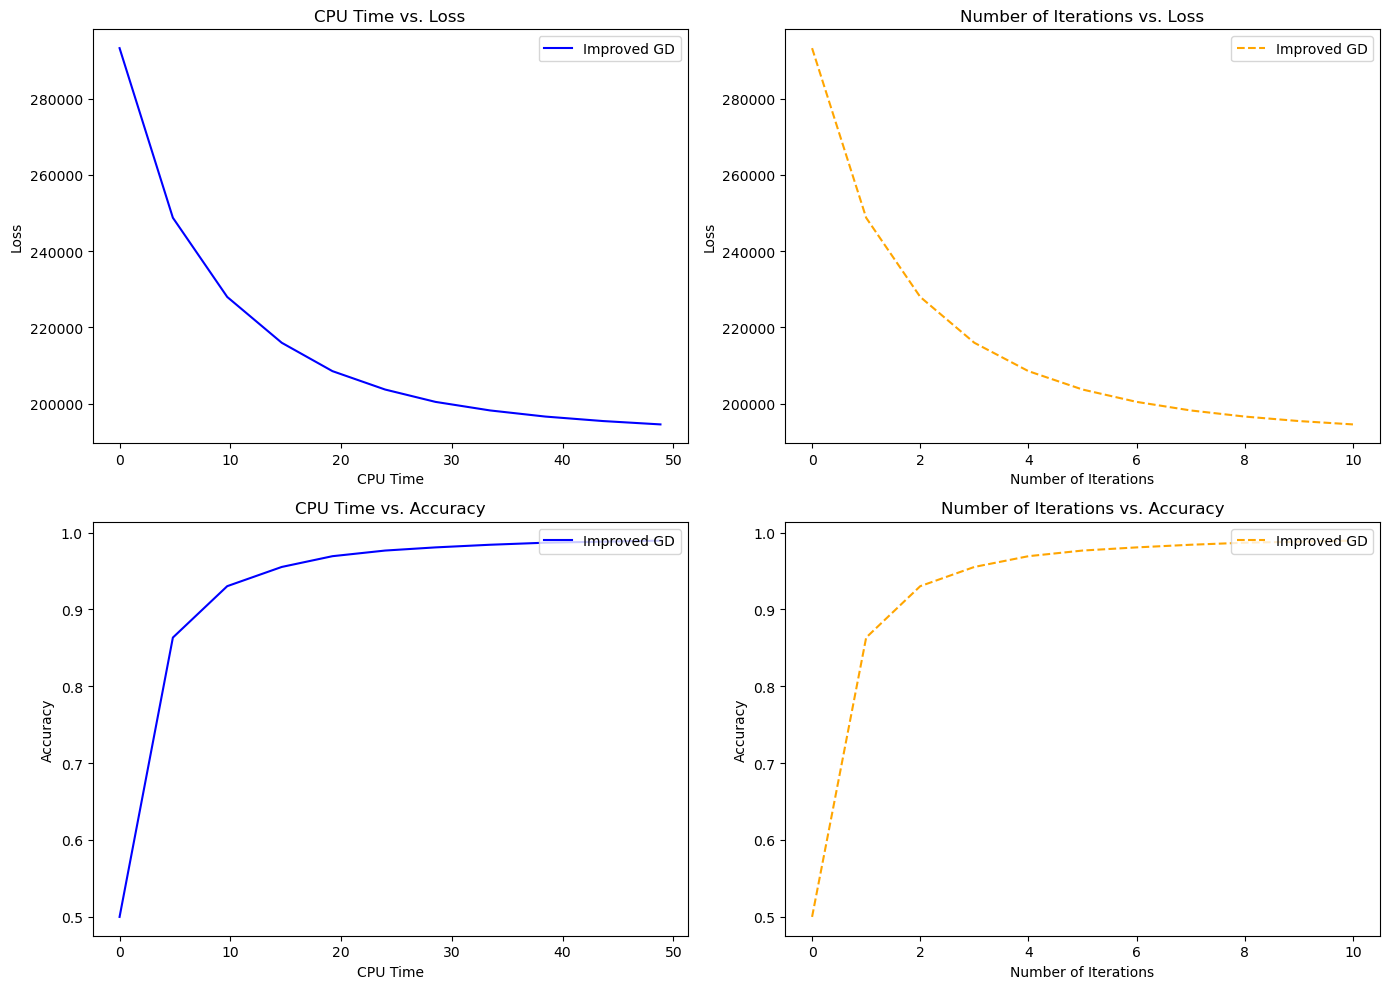

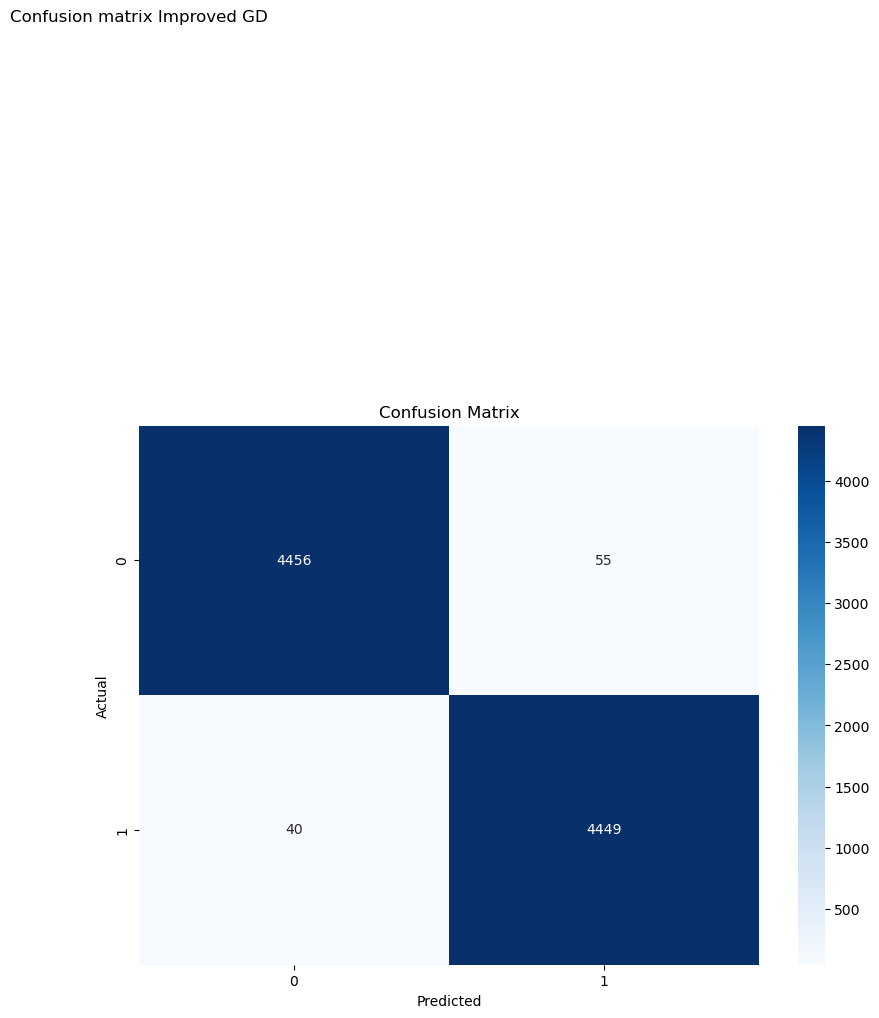

CPU times: total: 55 s
Wall time: 54.5 s


In [24]:
%%time
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

#Copy original unlabeled data
y_unlabeled_gd = np.random.uniform(low=-0.1, high=0.1, size=y_unlabeled.shape)

current_time = time.strftime("%Y%m%d-%H%M%S")

step_size = step_size
num_iters = 10
epsilon = 1e-4
gd_accuracies = []
gd_losses = []
gd_accuracies = [accuracy(y_unlabeled_target, y_unlabeled_gd)[0]]
gd_losses = [loss(y_labeled, y_unlabeled_gd)]
gd_cpu_times = [0]

start_time = time.process_time()  # Start measuring CPU time

for i in range(num_iters):
    grad_array = gradient(y_unlabeled_gd)

    if epsilon >= np.linalg.norm(grad_array):
        print('We stopped at iteration{}'.format(i))
        break

    y_unlabeled_gd = y_unlabeled_gd - step_size * grad_array
    acc, cm, f1 = accuracy(y_unlabeled_target, y_unlabeled_gd)
    gd_accuracies.append(acc)
    gd_losses.append(loss(y_labeled, y_unlabeled_gd))
    gd_cpu_times.append(time.process_time() - start_time)  # Calculate elapsed CPU time for each iteration

# Compute accuracy score, f1 score and confusion matrix
accuracy_score, cm, f1_score = accuracy(y_unlabeled_target, y_unlabeled_gd)

print(f"""
Final accuracy: {round(accuracy_score * 100, 2)}%
F1 Score: {f1_score}
Confusion Matrix:
{cm}
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd))}
Loss: {gd_losses[-1]}
""")

# Create a figure with a larger width
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Set some color and style constants
color1 = "blue"
color2 = "orange"
linestyle1 = '-'    # Solid line
linestyle2 = '--'   # Dashed line

# Plot the first figure: CPU time vs. loss
axs[0, 0].plot(gd_cpu_times, gd_losses, color=color1, linestyle=linestyle1, label='Improved GD')
axs[0, 0].set_xlabel('CPU Time')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('CPU Time vs. Loss')
axs[0, 0].legend(loc='upper right')  # Add a legend

# Plot the second figure: Number of iterations vs. loss
axs[0, 1].plot(range(len(gd_losses)), gd_losses, color=color2, linestyle=linestyle2, label='Improved GD')
axs[0, 1].set_xlabel('Number of Iterations')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_title('Number of Iterations vs. Loss')
axs[0, 1].legend(loc='upper right')  # Add a legend

# Plot the third figure: CPU time vs. accuracy
axs[1, 0].plot(gd_cpu_times, gd_accuracies, color=color1, linestyle=linestyle1, label='Improved GD')
axs[1, 0].set_xlabel('CPU Time')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_title('CPU Time vs. Accuracy')
axs[1, 0].legend(loc='upper right')  # Add a legend

# Plot the fourth figure: Number of iterations vs. accuracy
axs[1, 1].plot(range(len(gd_accuracies)), gd_accuracies, color=color2, linestyle=linestyle2, label='Improved GD')
axs[1, 1].set_xlabel('Number of Iterations')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_title('Number of Iterations vs. Accuracy')
axs[1, 1].legend(loc='upper right')  # Add a legend
axs[1, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
fig.savefig(os.path.join(output_dir, f"Number_of_Iterations_vs_Accuracy_{num_iters}_sigma_{sigma}.png"))

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figures
plt.show()

# Add confusion matrix plot at the end
import seaborn as sns

# Create a heatmap from the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.text(0, -1.5, 'Confusion matrix Improved GD', fontsize=12, ha='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [26]:
y_unlabeled_target[:10]

array([ 1,  1, -1,  1, -1,  1,  1,  1, -1, -1])

### Momentum-based gradient descent : Heavy Ball

$x_{k+1} = x_k - \alpha_k \nabla f(x_k) + \beta_k (x_k - x_{k-1})$
where  $x_{k} − x_{k−1}$,
which is usually called momentum, nudges $x_{k+1}$ in the direction of the previous
step


Final accuracy: 100.0%
F1 Score: 1.0
Confusion Matrix:
[[4511    0]
 [   0 4489]]
Norm gradient: 291.4452771222098
Loss: 191342.84570471037



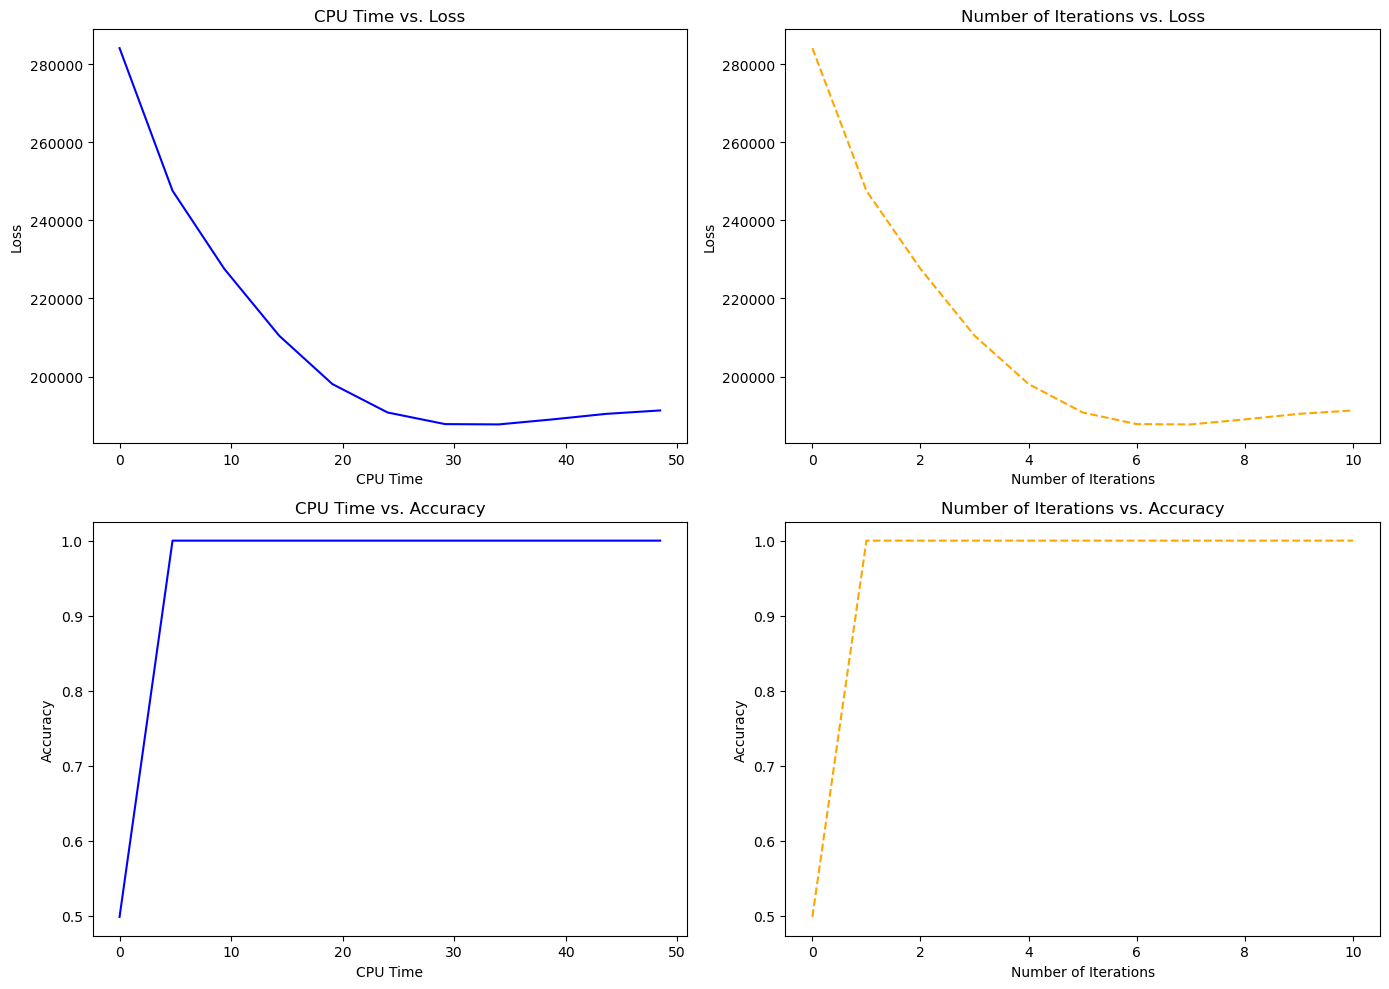

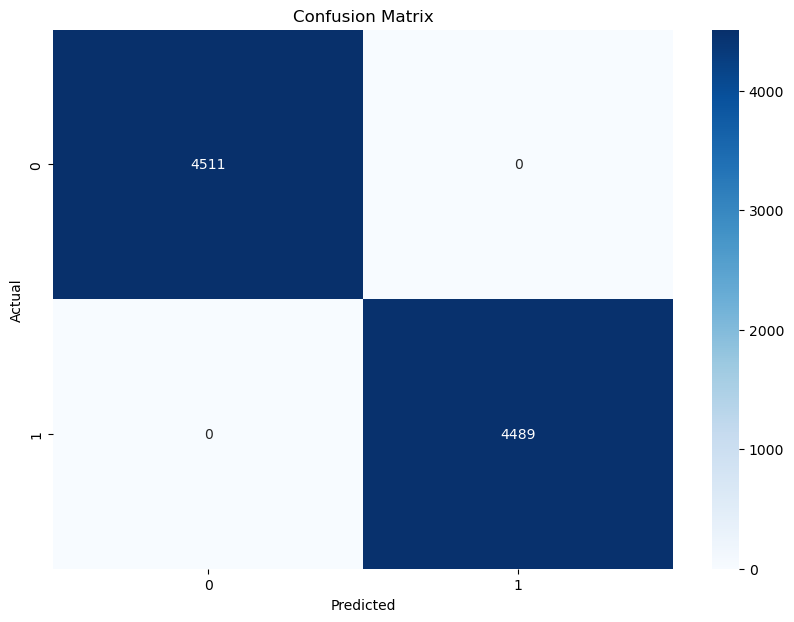

CPU times: total: 51.8 s
Wall time: 49.6 s


In [27]:
%%time

import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import math

# Copy original unlabeled data
y_unlabeled_hb_previous = y_unlabeled_hb = np.copy(y_unlabeled)
current_time = time.strftime("%Y%m%d-%H%M%S")

step_size = step_size
num_iters = 10
epsilon = 1e-4
hb_accuracies = []
hb_losses = []
hb_accuracies = [accuracy(y_unlabeled_target, y_unlabeled_hb)[0]]
hb_losses = [loss(y_labeled, y_unlabeled_hb)]
hb_cpu_times = [0]

start_time = time.process_time()  # Start measuring CPU time
Alpha = 0

for i in range(num_iters):
    grad_array = gradient(y_unlabeled_hb)

    if epsilon >= np.linalg.norm(grad_array):
        print('We stopped at iteration{}'.format(i))
        break

    new_Alpha = (1 + math.sqrt(1 + 4 * Alpha**2))/2
    Beta = (Alpha - 1) / new_Alpha
    Alpha = new_Alpha
    momentum = Beta * (y_unlabeled_hb - y_unlabeled_hb_previous)

    old_y_unlabeled_hb = np.copy(y_unlabeled_hb)
    y_unlabeled_hb = y_unlabeled_hb - step_size * grad_array + momentum
    y_unlabeled_hb_previous = old_y_unlabeled_hb

    acc, cm, f1 = accuracy(y_unlabeled_target, y_unlabeled_hb)
    hb_accuracies.append(acc)
    hb_losses.append(loss(y_labeled, y_unlabeled_hb))
    hb_cpu_times.append(time.process_time() - start_time)  # Calculate elapsed CPU time for each iteration

# After the loop ends, get the final predictions
y_unlabeled_hb_binary = np.where(y_unlabeled_hb >= 0, 1, -1)

# Compute accuracy score, f1 score and confusion matrix
accuracy_score, cm, f1_score = accuracy(y_unlabeled_target, y_unlabeled_hb_binary)

print(f"""
Final accuracy: {round(accuracy_score * 100, 2)}%
F1 Score: {f1_score}
Confusion Matrix:
{cm}
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_hb))}
Loss: {hb_losses[-1]}
""")

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

color1 = "blue"
color2 = "orange"
linestyle1 = '-'    # Solid line
linestyle2 = '--'   # Dashed line

axs[0, 0].plot(hb_cpu_times, hb_losses, color=color1, linestyle=linestyle1)
axs[0, 0].set_xlabel('CPU Time')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('CPU Time vs. Loss')

axs[0, 1].plot(range(len(hb_losses)), hb_losses, color=color2, linestyle=linestyle2)
axs[0, 1].set_xlabel('Number of Iterations')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_title('Number of Iterations vs. Loss')
axs[0, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

axs[1, 0].plot(hb_cpu_times, hb_accuracies, color=color1, linestyle=linestyle1)
axs[1, 0].set_xlabel('CPU Time')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_title('CPU Time vs. Accuracy')

axs[1, 1].plot(range(len(hb_accuracies)), hb_accuracies, color=color2, linestyle=linestyle2)
axs[1, 1].set_xlabel('Number of Iterations')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_title('Number of Iterations vs. Accuracy')
axs[1, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
fig.savefig(os.path.join(output_dir, f"Number_of_Iterations_vs_Accuracy_{num_iters}_sigma_{sigma}_{current_time}.png"))


plt.tight_layout()
plt.show()

# Add confusion matrix plot at the end
import seaborn as sns

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.savefig(os.path.join(output_dir, f"Confusion_Matrix_{current_time}.png"))
plt.show()

In [566]:
print(len(gd_cpu_times))

51


In [567]:
print(len(hb_cpu_times))

51


In [568]:
len(hb_losses)

51

In [569]:
len(gd_losses)

51

### Comparison GD vs Heavy Ball

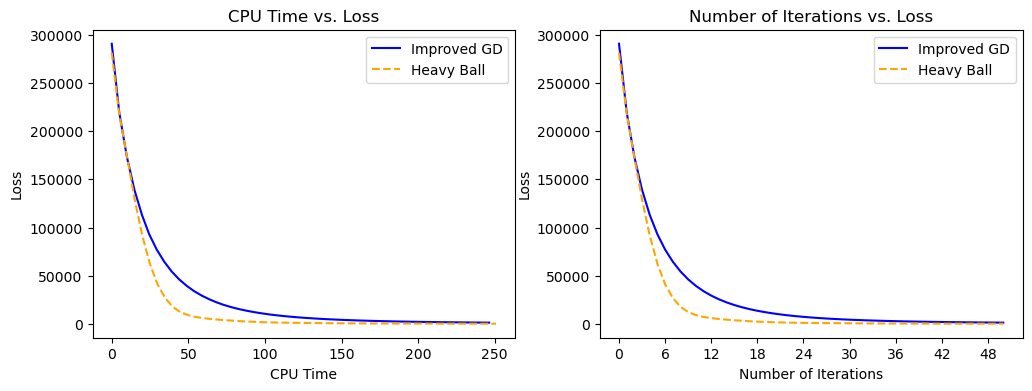

In [570]:
# Create a figure with a larger width
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Set some color and style constants
color_gd = "blue"
color_hb = "orange"
linestyle1 = '-'    # Solid line
linestyle2 = '--'   # Dashed line

# Plot the first figure: CPU time vs. loss
axs[0].plot(gd_cpu_times, gd_losses, color=color_gd, linestyle=linestyle1, label='Improved GD')
axs[0].plot(hb_cpu_times, hb_losses, color=color_hb, linestyle=linestyle2, label='Heavy Ball')
axs[0].set_xlabel('CPU Time')
axs[0].set_ylabel('Loss')
axs[0].set_title('CPU Time vs. Loss')
axs[0].legend()

# Plot the second figure: Number of iterations vs. loss
axs[1].plot(range(len(gd_losses)), gd_losses, color=color_gd, linestyle=linestyle1, label='Improved GD')
axs[1].plot(range(len(hb_losses)), hb_losses, color=color_hb, linestyle=linestyle2, label='Heavy Ball')
axs[1].set_xlabel('Number of Iterations')
axs[1].set_ylabel('Loss')
axs[1].set_title('Number of Iterations vs. Loss')
axs[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axs[1].legend()

### Block Coordinate Gradient Descent : Randomized

In [547]:
%%time
# Define a Lipschitz constant for each unlabeled data point
Li = np.array([hessian[i][i] for i in range(len(hessian))], dtype='float64')

CPU times: total: 0 ns
Wall time: 769 ms


In [449]:
# since one block is 9000, one "iteration" is updating 9000 variables
number_of_iters = 50
max_iter = len(y_unlabeled)*number_of_iters
max_iter

450000

In [459]:
%%time

# Make a copy of the unlabeled data
y_unlabeled_bcgd_random = np.copy(y_unlabeled).astype(np.float64)

# Define the improved probability measure using the array of Lipschitz constants
improved_prob = Li / np.sum(Li)

grad_bcgd = gradient(y_unlabeled_bcgd_random)
bcgd_rand_accuracies = [accuracy(y_unlabeled_target, y_unlabeled_bcgd_random)]
bcgd_rand_losses = [loss(y_labeled, y_unlabeled_bcgd_random)]

# Select a random index according to the improved probability measure
indices = np.random.choice(len(y_unlabeled_bcgd_random), max_iter, p=improved_prob)

start_time_bcgd_rand = time.process_time()  # Start measuring CPU time
cpu_times_bcgd_rand = [0]
for i in range(max_iter):
    
    j = indices[i]
    
    # Calculate the gradient at the unlabeled data point with index j
    grad_j = grad_first_term[j] * y_unlabeled_bcgd_random[j] - \
             grad_second_term[j] - \
             np.matmul(w_unlabeled_unlabeled[:,j], y_unlabeled_bcgd_random.T)

    # Replace the gradient of index j in the original gradient array
    grad_bcgd[j] = grad_j

    # Update the unlabeled data point with index j
    y_unlabeled_bcgd_random[j] -= grad_j[0] / (Li[j])
    
    # Calculate accuracy and loss at each iteration
    if j % len(y_unlabeled_target) == 0:
        acc = accuracy(y_unlabeled_target, y_unlabeled_bcgd_random)
        loss_val = loss(y_labeled, y_unlabeled_bcgd_random)
        bcgd_rand_accuracies.append(acc)
        bcgd_rand_losses.append(loss_val)
        cpu_times_bcgd_rand.append(time.process_time() - start_time_bcgd_rand)

    # Check stopping condition
    grad_norm = np.linalg.norm(grad_bcgd)
    if grad_norm < epsilon:
        print(f"We stopped at iteration {i}")
        break

acc = accuracy(y_unlabeled_target, y_unlabeled_bcgd_random)
loss_val = loss(y_labeled, y_unlabeled_bcgd_random)
bcgd_rand_accuracies.append(acc)
bcgd_rand_losses.append(loss_val)
cpu_times_bcgd_rand.append(time.process_time() - start_time_bcgd_rand)  # Calculate elapsed CPU time for each iteration

print(f"""
Final accuracy: {round(bcgd_rand_accuracies[-1] * 100, 2)}%
Norm gradient: {grad_norm}
Loss: {bcgd_rand_losses[-1]}
""")

# Create a figure with a larger width
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Set some color and style constants
color1 = "blue"
color2 = "orange"
linestyle1 = '-'    # Solid line
linestyle2 = '--'   # Dashed line

# Plot the first figure: CPU time vs. loss
axs[0, 0].plot(cpu_times_bcgd_rand, bcgd_rand_losses, color=color1, linestyle=linestyle1)
axs[0, 0].set_xlabel('CPU Time')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('CPU Time vs. Loss')

# Plot the second figure: Number of iterations vs. loss
axs[0, 1].plot(range(len(bcgd_rand_losses)), bcgd_rand_losses, color=color2, linestyle=linestyle2)
axs[0, 1].set_xlabel('Number of Iterations')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_title('Number of Iterations vs. Loss')
axs[0, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Plot the third figure: CPU time vs. accuracy
axs[1, 0].plot(cpu_times_bcgd_rand, bcgd_rand_accuracies, color=color1, linestyle=linestyle1)
axs[1, 0].set_xlabel('CPU Time')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_title('CPU Time vs. Accuracy')

# Plot the fourth figure: Number of iterations vs. accuracy
axs[1, 1].plot(range(len(bcgd_rand_accuracies)), bcgd_rand_accuracies, color=color2, linestyle=linestyle2)
axs[1, 1].set_xlabel('Number of Iterations')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_title('Number of Iterations vs. Accuracy')
axs[1, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figures
plt.show()

TypeError: type tuple doesn't define __round__ method